# Testing different dynamical systems-inspired training strategies for RNNs and NeuralODEs

We will start out by using the Lorenz63 system:

\begin{aligned}
&\dot{x} = \sigma(y-x)\\
&\dot{y} = x(\rho-z)-y\\
&\dot{z} = xy-\beta z
\end{aligned}

with the parameters $\sigma = 10, \beta = 8/3, \rho = 28$ chosen so that the system displays chaotic behavior.

Following Hess et al. Generalized Teacher Forcing for Learning Chaotic Dynamics, ICML (2023)., the train and test sets are each comprised of a single trajectory 
with initial condition chosen as $\boldsymbol{u_0} = (x_0, y_0, z_0)^T \sim \mathscr{N}(\boldsymbol{0}, \boldsymbol{I})$ with $t=\{i\Delta t\}_{i=0}^{N-1}$ with $\Delta t = 0.01$ and $N=10^5$.

The training set is contaminated with Gaussian observation noise corresponding to 5% of the data standard deviation.

In [1]:
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.dataset import TimeSeriesDataset
from dynamics_discovery.models import NeuralODE
from dynamics_discovery.models.latent_rnn import LatentLSTM
from dynamics_discovery.preprocessing import split_into_chunks, standardize
from jaxtyping import Array, Float
from matplotlib_utils.axes_setters import set_labels


jax.config.update("jax_enable_x64", True)

In [2]:
lorenz = Lorenz63()
lorenz

Lorenz63(sigma=10, beta=2.6666666666666665, rho=28)

In [3]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz.hdf5")
u0 = dataset_loaded.u0
u0

Array([[-0.20584214, -0.78476578,  1.81608667],
       [ 0.18784401,  0.08086788, -0.37211079]], dtype=float64)

In [4]:
# dataset_loaded = jnp.load("./data/lorenz_data_chaos.npy")
# dataset_loaded.shape

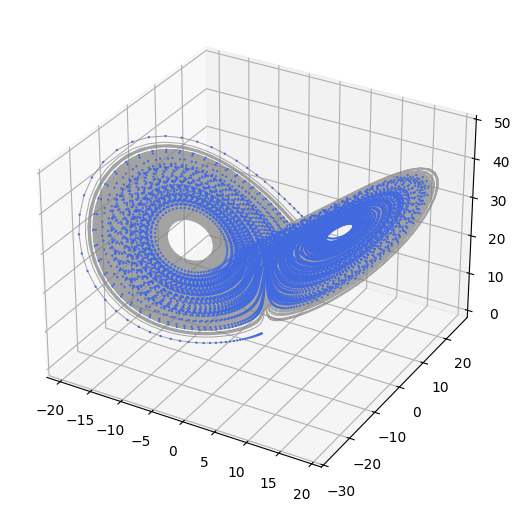

In [5]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(7, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
ax.plot(*dataset_loaded.u[0].T, linewidth=0.7, color="gray", alpha=0.7)
ax.scatter(*dataset_loaded.u[0, :10000].T, s=0.5, color="royalblue", alpha=0.9)

In [6]:
# dataset_other = TimeSeriesDataset.from_dynamical_system(
#     lorenz, dataset_loaded.t, dataset_loaded.u0, rtol=1e-4, atol=1e-4
# )

In [7]:
# dataset_other.save("./data/lorenz_larger_tol.hdf5")

In [8]:
u_train_test = dataset_loaded.u  # [:, :10000]
do_standardize = True
if do_standardize:
    print("Standardized")
    u_train, u_test = standardize(*u_train_test)
else:
    u_train, u_test = u_train_test

Standardized


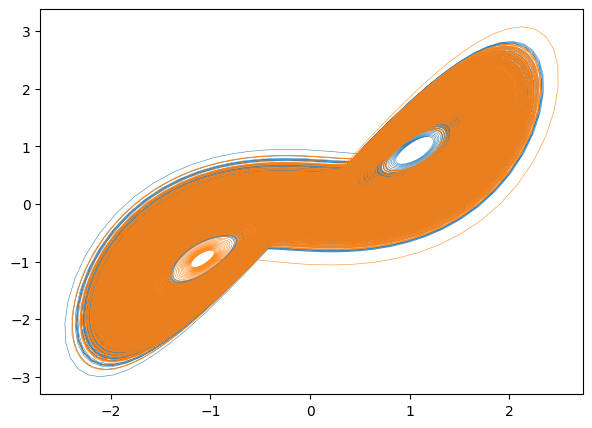

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot_kwargs = {"linewidth": 0.4, "alpha": 0.9}
ax.plot(u_train[:, 0], u_train[:, 1], **plot_kwargs)
ax.plot(u_test[:, 0], u_test[:, 1], **plot_kwargs)

In [10]:
chunk_length = 77
t = dataset_loaded.t  # [:10000]  # TODO: implement __getitem__ for the dataset class
t_train_batched = split_into_chunks(t, chunk_length)
u_train_batched = split_into_chunks(u_train, chunk_length)

u_train_batched.shape

(1298, 77, 3)

In [11]:
lstm = LatentLSTM(3, 30)

In [12]:
import operator


jax.tree.reduce(
    operator.add, jax.tree.map(jnp.size, eqx.filter(lstm, eqx.is_inexact_array))
)

3933

In [13]:
state0 = lstm.to_latent(u_train_batched[0, 0])
state0

(Array([ 0.00506177,  0.27194635,  0.58321241,  1.35201887, -2.51248382,
         0.37887732,  0.2953999 , -1.32806529, -0.12113319,  0.29358155,
        -0.49416557, -0.87871409,  0.7186025 , -0.65005619, -0.3659701 ,
        -1.10455198, -0.9122028 ,  0.92274655,  1.05276591, -0.02448899,
         0.0979923 ,  0.34738609,  1.25238019,  2.21773034,  1.6410574 ,
        -0.14541827, -0.27861459, -0.57949885,  0.60022093, -1.70446895],      dtype=float64),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64))

In [14]:
lstm.latent_step(0.0, 0.01, state0)

(Array([-0.00562023, -0.22134461, -0.12991492, -0.04382232,  0.08911925,
         0.07637268,  0.00701058,  0.11588617, -0.09197116, -0.03626562,
         0.00147986,  0.26463176, -0.2250998 ,  0.1061023 ,  0.14584709,
         0.07634456, -0.10677516,  0.00728638,  0.1589858 , -0.00088212,
        -0.13011002,  0.02802917,  0.12566223,  0.01564605, -0.04414016,
        -0.12390506, -0.01745267,  0.13928554, -0.01810288, -0.023233  ],      dtype=float64),
 Array([-0.0105488 , -0.40907642, -0.30116612, -0.06039175,  0.12542988,
         0.10467741,  0.01519968,  0.31131364, -0.12264709, -0.08182861,
         0.00826637,  0.53105644, -0.32651511,  0.26727518,  0.33581433,
         0.12088671, -0.23032426,  0.01231966,  0.32743821, -0.0025998 ,
        -0.31219732,  0.09886782,  0.30315773,  0.02289633, -0.09767063,
        -0.18705674, -0.05281578,  0.20125722, -0.0359935 , -0.03053234],      dtype=float64))

In [15]:
neuralode = NeuralODE(3, 32, 3, rtol=1e-4, atol=1e-4)


@eqx.filter_jit
@partial(eqx.filter_vmap, in_axes=(None, 0, 0))
def solve_model(model, t, u0, args=None, **kwargs):
    u_pred = model.solve(t, u0, args)
    return u_pred


u_pred = solve_model(neuralode, t_train_batched, u_train_batched[:, 0])


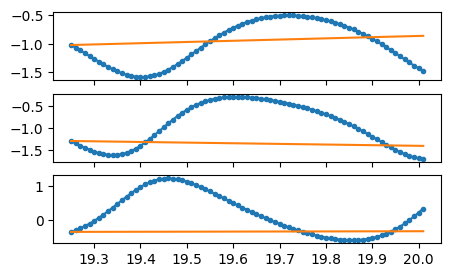

In [16]:
chunk_idx = 25
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i], ".-")
    ax.plot(t_train_batched[chunk_idx], u_pred[chunk_idx, :, i])

In [17]:
def loss_mse(
    model,
    t_data: Float[Array, "batch time"],
    u_data: Float[Array, "batch time dim"],
    u0_data=None,
):
    del u0_data

    u_pred = solve_model(model, t_data, u_data[:, 0])
    return jnp.mean((u_pred - u_data) ** 2)


def train_vanilla(
    model,
    t_data,
    u_data,
    u0_data=None,
    loss_fn=loss_mse,
    optimizer_fn=optax.adabelief,
    lr: float = 1e-3,
    max_epochs: int = 10000,
):
    optimizer = optimizer_fn(lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

    @eqx.filter_value_and_grad
    def loss_grad_fn(model, t_batch, u_batch, u0_batch):
        return loss_fn(model, t_batch, u_batch, u0_batch)

    @eqx.filter_jit
    def make_step(model, t_data, u_data, u0_data, opt_state):
        loss, grads = loss_grad_fn(model, t_data, u_data, u0_data)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    loss_history = []
    for epoch in range(max_epochs):
        loss, model, opt_state = make_step(model, t_data, u_data, u0_data, opt_state)
        print(f"{epoch=}, {loss=}")
        loss_history.append(loss.item())

    return model, jnp.asarray(loss_history)


In [18]:
model, loss_history = train_vanilla(
    neuralode, t_train_batched, u_train_batched, lr=2e-3, max_epochs=500
)

epoch=0, loss=Array(1.54321236, dtype=float64)
epoch=1, loss=Array(1.53749505, dtype=float64)
epoch=2, loss=Array(1.53163544, dtype=float64)
epoch=3, loss=Array(1.52553299, dtype=float64)
epoch=4, loss=Array(1.51905585, dtype=float64)
epoch=5, loss=Array(1.51203356, dtype=float64)
epoch=6, loss=Array(1.50426295, dtype=float64)
epoch=7, loss=Array(1.49551678, dtype=float64)
epoch=8, loss=Array(1.4855503, dtype=float64)
epoch=9, loss=Array(1.4741053, dtype=float64)
epoch=10, loss=Array(1.46091473, dtype=float64)
epoch=11, loss=Array(1.44571068, dtype=float64)
epoch=12, loss=Array(1.42823639, dtype=float64)
epoch=13, loss=Array(1.40826173, dtype=float64)
epoch=14, loss=Array(1.38560188, dtype=float64)
epoch=15, loss=Array(1.36014009, dtype=float64)
epoch=16, loss=Array(1.33185466, dtype=float64)
epoch=17, loss=Array(1.30084848, dtype=float64)
epoch=18, loss=Array(1.26737897, dtype=float64)
epoch=19, loss=Array(1.23188504, dtype=float64)
epoch=20, loss=Array(1.19499351, dtype=float64)
epoc

Text(0.5, 1.0, 'NeuralODE loss curve (train length = 77)')

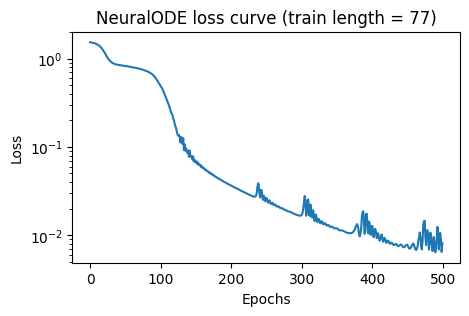

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(jnp.asarray(loss_history))
ax.set_yscale("log", base=10)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title(f"NeuralODE loss curve (train length = {chunk_length})")

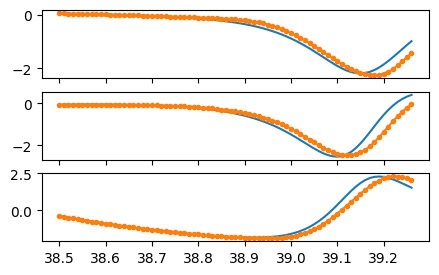

In [20]:
u_pred = solve_model(model, t_train_batched, u_train_batched[:, 0])

chunk_idx = 50
fig, axes = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_train_batched[chunk_idx], u_train_batched[chunk_idx, :, i])
    ax.plot(t_train_batched[chunk_idx], u_pred[chunk_idx, :, i], ".-")

In [24]:
u_pred_test = model.solve(t, u_test[0], max_steps=None)

In [25]:
u_pred_test.shape

(100000, 3)

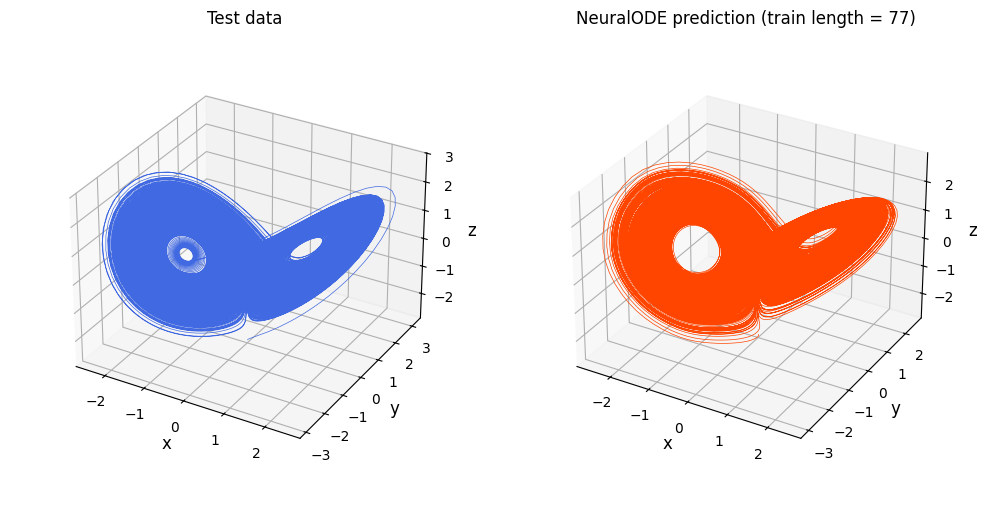

In [26]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].plot(*u_test.T, color="royalblue", **plot_kwargs)
axes[0].set_title("Test data")
axes[1].plot(*u_pred_test.T, color="orangered", **plot_kwargs)
axes[1].set_title(f"NeuralODE prediction (train length = {chunk_length})")
for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)